In [8]:
def make_multistep_target(ts, steps):
    '''
    ts: una serie cuyos indices sean los tiempos.

    steps: int.  Numero de pasos a realizar
    '''
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax



plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

In [3]:
from perfil_binance import cuenta_binance as cb 
import Datasets
from pathlib import Path
from warnings import simplefilter
import tools_ml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import timedelta
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [103]:
# creacion del conector
real = cb('real')
precio_str = 'high'
simbolo = 'BTCUSDT'
intervalo = '1d'

df = Datasets.historical(cliente=real, simbolo=simbolo, intervalo=intervalo, limite=30)
df.index = df.open_time



---------Cuenta real----------


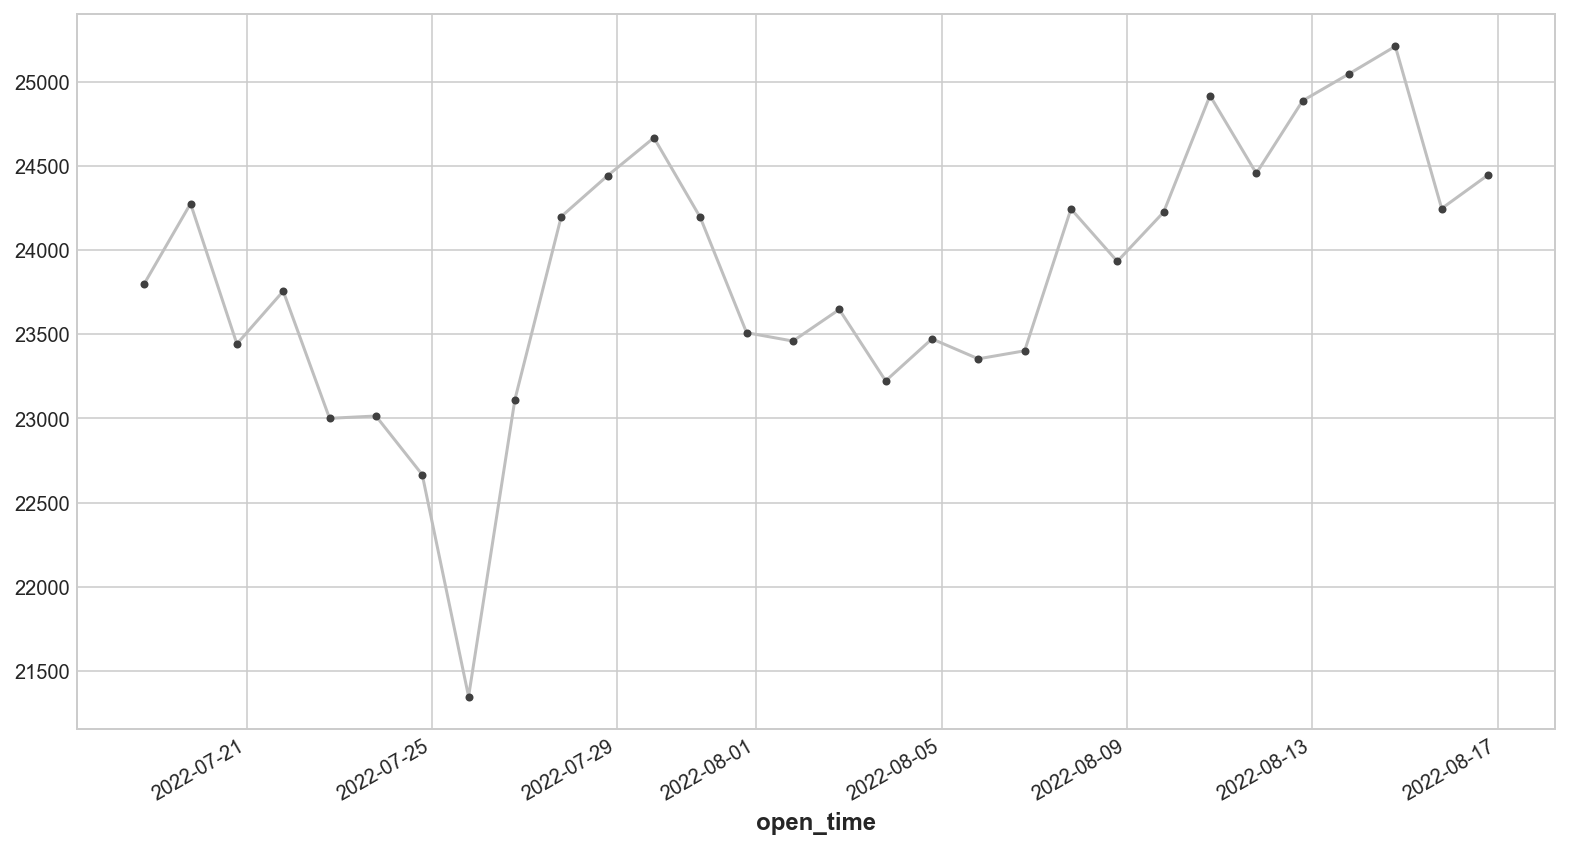

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(11, 6))
ax = df[precio_str].plot(**plot_params, ax=ax)
plt.show()

# Modelo simple de regresion (time-step features)

El modelo de regresion que ejecutaremos con el dummy es:
    
    objetivo = peso * tiempo + sesgo

In [105]:
# Preparacion de datos
y_simple = pd.DataFrame({precio_str: df[precio_str].copy()})
y_simple['Time'] = np.arange(len(df.index))
y_simple

,high,Time
open_time,,
2022-07-18 19:00:00,23800.00,0
2022-07-19 19:00:00,24276.74,1
2022-07-20 19:00:00,23442.77,2
2022-07-21 19:00:00,23756.49,3
2022-07-22 19:00:00,23000.77,4
2022-07-23 19:00:00,23014.64,5
2022-07-24 19:00:00,22666.00,6
2022-07-25 19:00:00,21347.82,7
2022-07-26 19:00:00,23112.63,8


In [106]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'


### Grafica para observar la tendencia.

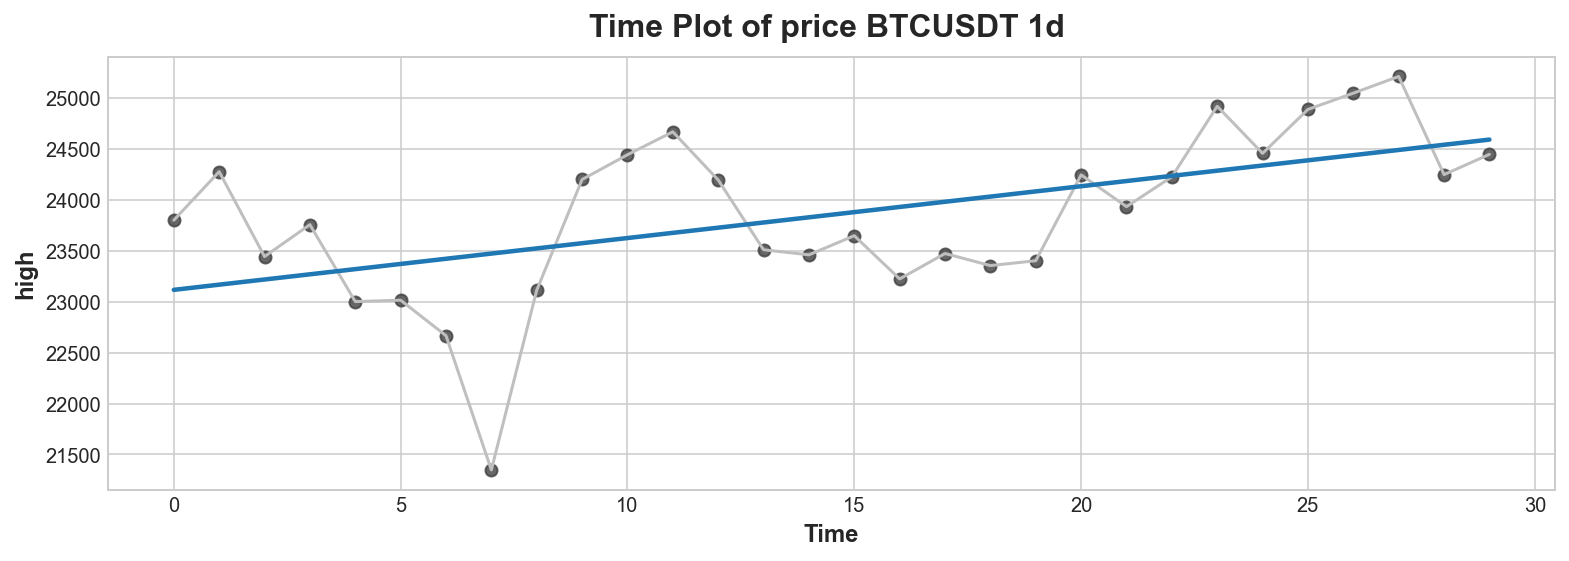

In [107]:
fig, ax = plt.subplots()
ax.plot('Time', precio_str, data=y_simple, color='0.75')
ax = sns.regplot(x='Time', y=precio_str, data=y_simple, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title(f'Time Plot of price {simbolo + " " + intervalo} ');

### Entrenando el modelo

In [108]:
from sklearn.linear_model import LinearRegression

# Training data
X = y_simple.loc[:, ['Time']]  # features
y = y_simple.loc[:, precio_str]  # target

# Train the model
model = LinearRegression()
model.fit(X, y)
print('La R^2 es: ', model.score(X,y))
# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

La R^2 es:  0.30253805113946075


In [109]:
print('Modelo'.center(50,'*') , '\n')
print(f'objetivo = {model.coef_[0]} Time +  {model.intercept_}')

**********************Modelo********************** 

objetivo = 50.87650278086762 Time +  23116.064709677416


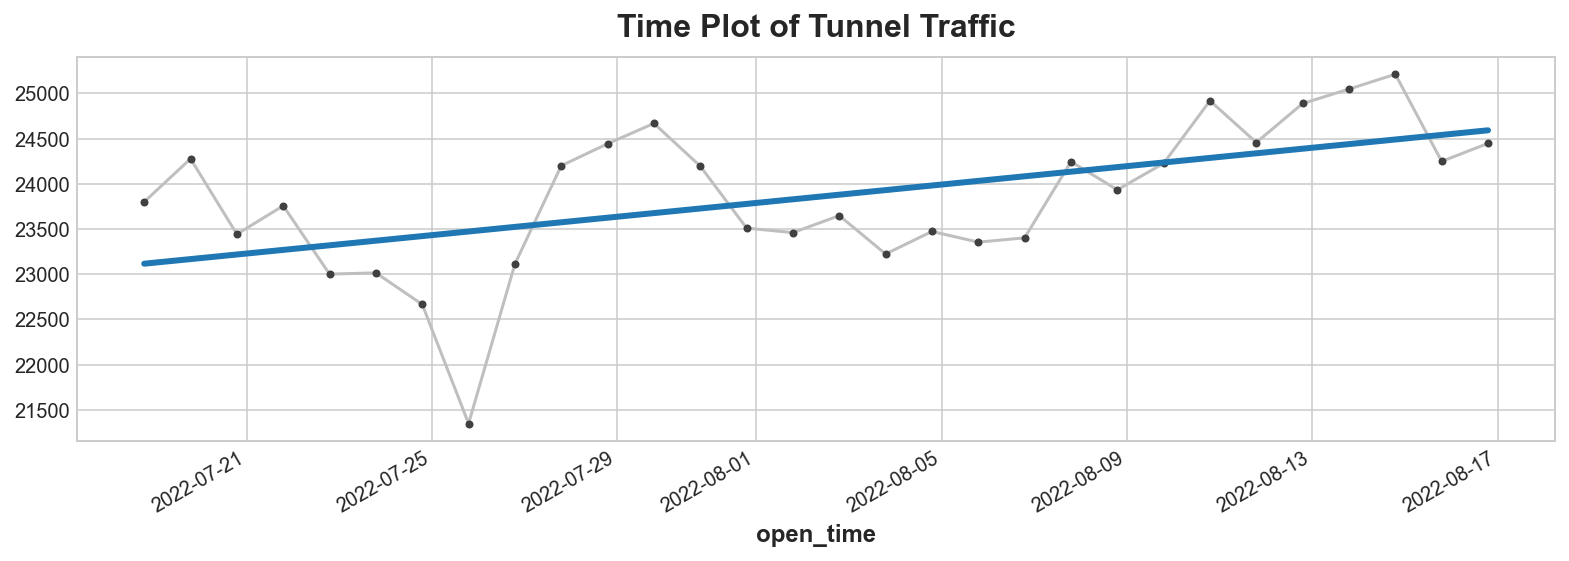

In [110]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

In [114]:
ultimo_periodo = y_simple.Time[-1]
ultimo_indice = y_simple.index[-1]
periodos_predecir = 5

x_predic = pd.DataFrame({'Time':np.arange(ultimo_periodo, ultimo_periodo+1+periodos_predecir)},
                    index=pd.date_range(start=ultimo_indice , end=ultimo_indice + timedelta(days=periodos_predecir)))

y_pred = pd.Series(model.predict(x_predic.loc[:,['Time']]), index=x_predic.index)


In [115]:
y_pred

2022-08-16 19:00:00    24591.483290
2022-08-17 19:00:00    24642.359793
2022-08-18 19:00:00    24693.236296
2022-08-19 19:00:00    24744.112799
2022-08-20 19:00:00    24794.989301
2022-08-21 19:00:00    24845.865804
Freq: D, dtype: float64

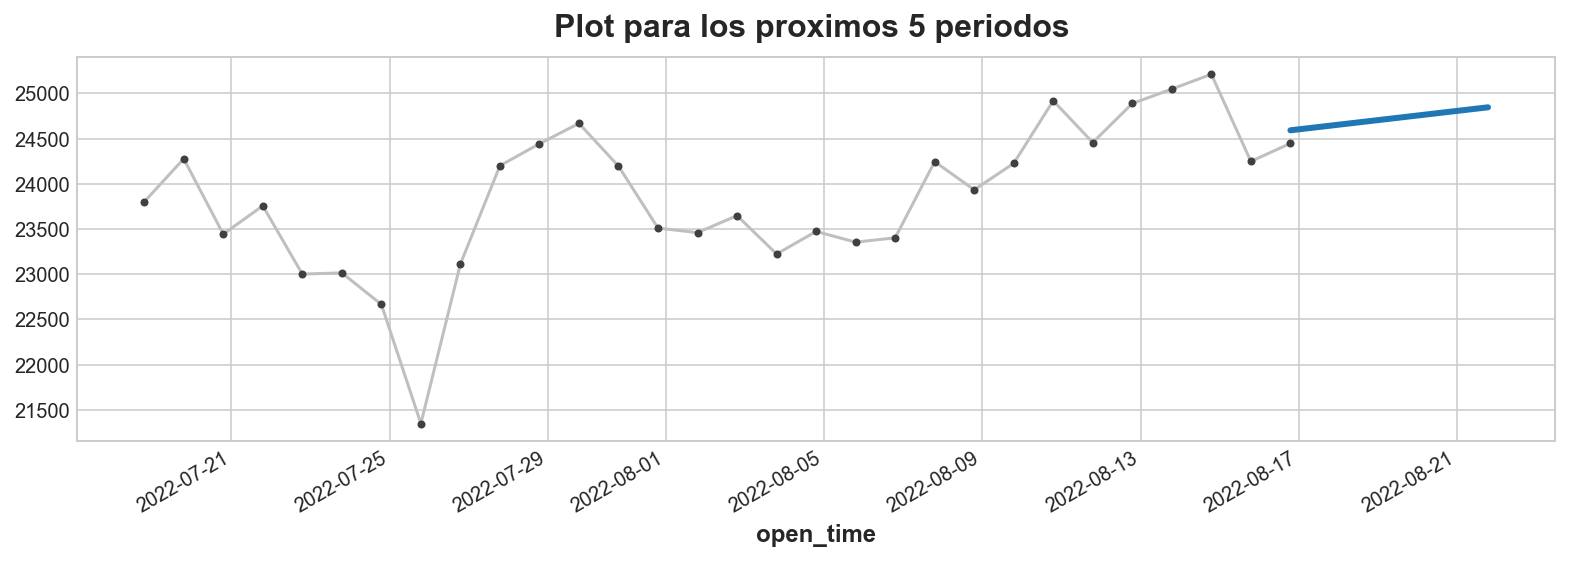

In [116]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title(f'Plot para los proximos {periodos_predecir} periodos ');

# Funcion de retraso
La regresion lineal con el campo de retraso produce el modelo:

    objetivo = peso * lag_1 + bias
Entonces, las características de retraso nos permiten ajustar curvas a diagramas de retraso donde cada observación en una serie se grafica contra la observación anterior.

In [117]:
y_retraso = pd.DataFrame({precio_str:df[precio_str]})
y_retraso['Lag'] = y_retraso[precio_str].shift(1)
y_retraso

,high,Lag
open_time,,
2022-07-18 19:00:00,23800.00,NaN
2022-07-19 19:00:00,24276.74,23800.00
2022-07-20 19:00:00,23442.77,24276.74
2022-07-21 19:00:00,23756.49,23442.77
2022-07-22 19:00:00,23000.77,23756.49
2022-07-23 19:00:00,23014.64,23000.77
2022-07-24 19:00:00,22666.00,23014.64
2022-07-25 19:00:00,21347.82,22666.00
2022-07-26 19:00:00,23112.63,21347.82


### Graficamos para ver la correlacion entre el precio actual y el pasado.

¿Que tan relevante es el precio anterior?

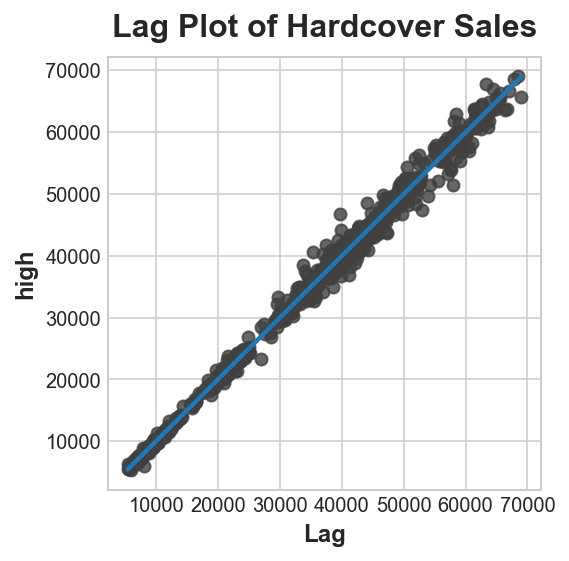

In [43]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag', y=precio_str, data=y_retraso, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');

### Entrenando el modelo

In [120]:
from sklearn.linear_model import LinearRegression

X = y_retraso.loc[:, ['Lag']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = y_retraso.loc[:, precio_str]  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
print(f'La R^2 del modelo es: {model.score(X,y)}')

La R^2 del modelo es: 0.482737916985426


### Grafico de retraso 
muestra que tan bien pudimos ajustar la relacion entre el precio de un dia con el anterior.

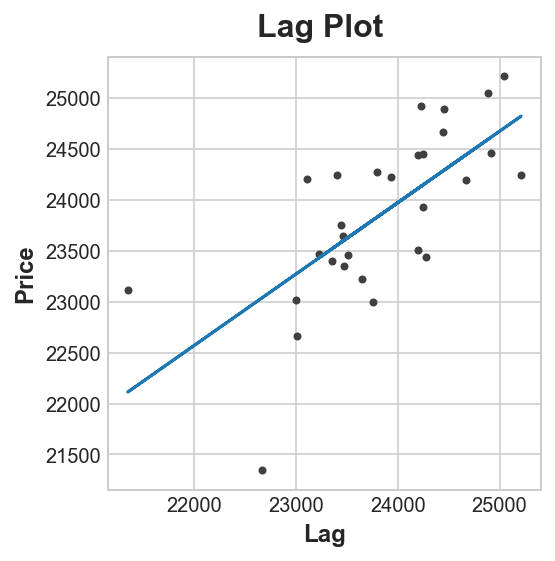

In [121]:
fig, ax = plt.subplots()
ax.plot(X['Lag'], y, '.', color='0.25')
ax.plot(X['Lag'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('Price')
ax.set_xlabel('Lag')
ax.set_title('Lag Plot ');

### Grafico de prediccion

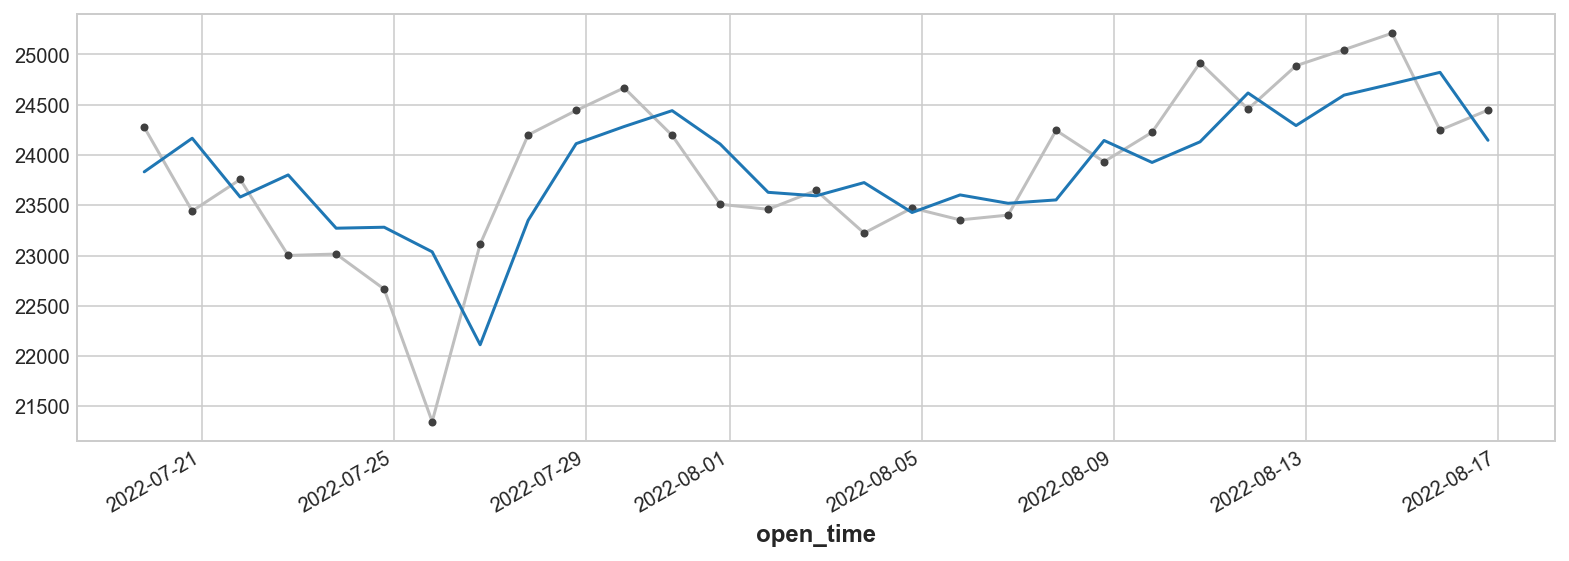

In [122]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

In [20]:


y_orig = df[precio_str].copy()
y = df[precio_str].copy()

X = tools_ml.make_lags(y,1).fillna(0)

y = tools_ml.make_multistep_target(y, steps=10).fillna(0.0) #.dropna()
print(y)
# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

                     y_step_1  y_step_2  y_step_3  y_step_4  y_step_5  \
open_time                                                               
2019-11-21 19:00:00   7750.00   7344.48   7330.39   7377.69   7340.00   
2019-11-22 19:00:00   7344.48   7330.39   7377.69   7340.00   7655.00   
2019-11-23 19:00:00   7330.39   7377.69   7340.00   7655.00   7643.00   
2019-11-24 19:00:00   7377.69   7340.00   7655.00   7643.00   7850.00   
2019-11-25 19:00:00   7340.00   7655.00   7643.00   7850.00   7810.00   
...                       ...       ...       ...       ...       ...   
2022-08-12 19:00:00  24888.00  25047.56  25211.32  24247.49  24446.71   
2022-08-13 19:00:00  25047.56  25211.32  24247.49  24446.71      0.00   
2022-08-14 19:00:00  25211.32  24247.49  24446.71      0.00      0.00   
2022-08-15 19:00:00  24247.49  24446.71      0.00      0.00      0.00   
2022-08-16 19:00:00  24446.71      0.00      0.00      0.00      0.00   

                     y_step_6  y_step_7  y_step_8 

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)


## Modelo Multiple salida

In [24]:
model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 2932.17
Test RMSE: 4127.25


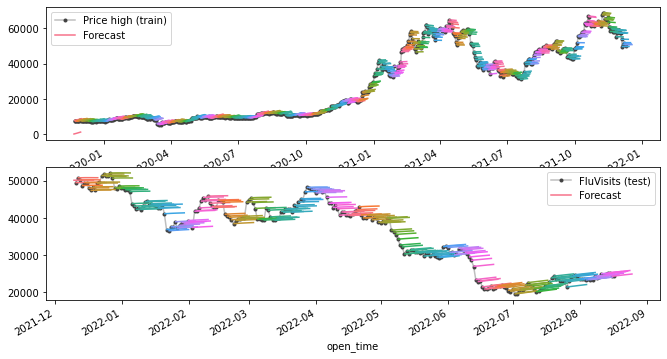

In [25]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))

ax1 = y_orig[y_fit.index].plot(**plot_params, ax=ax1)

ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)

_ = ax1.legend([f'Price {precio_str} (train)', 'Forecast'])
ax2 =  y_orig[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

### Conclusion:
Este modelo no ajusta bien los precios de TRXUSDT.

No es bueno para periodos menores a 1d


Es bueno para BTCUSDT

## Estrategia directa

In [26]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 918.03
Test RMSE: 6145.41


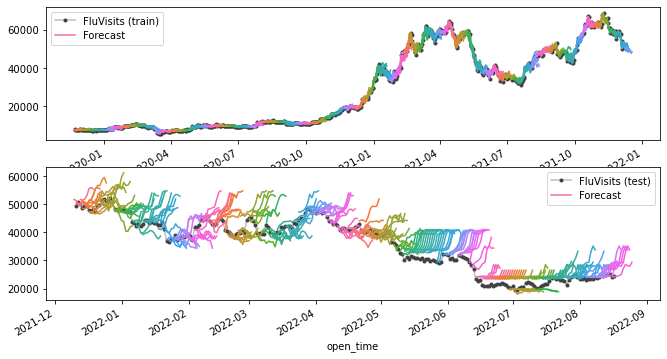

In [27]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = y_orig[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = y_orig[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

## Conclusiones:
No ajusta bien BTCUSDT, pero para TRXUSDT es bueno.

In [106]:
from sklearn.metrics import accuracy_score
(y_test.iloc[-1,:], y_pred.iloc[-1,:])

(y_step_1    0.07059
 y_step_2    0.00000
 y_step_3    0.00000
 Name: 2022-08-15 19:00:00, dtype: float64,
 y_step_1    0.068906
 y_step_2    0.068011
 y_step_3    0.067696
 Name: 2022-08-15 19:00:00, dtype: float32)